# Biped with arms on Skateboard - SO

### Perform the standing ollie using a biped model with arms

In [121]:
# import my libraries
import eomlib_biped_with_arms
import skaterlib_biped_with_arms
from importlib import reload
# import Python libraries
import cloudpickle
import numpy as np
import time
import winsound
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

reload(eomlib_biped_with_arms);
reload(skaterlib_biped_with_arms);

# Open a model to initialize the trajectory
model = 'model_biped_arms_SO_N65_29_09_2019_23_07.pkl' # working, 0.5m ollie, dq = 0 at N
model = 'model_biped_arms_SO_N65_30_09_2019_23_28.pkl' # working, 0.5m ollie, dq = 0 at N

filepath = 'saved_models\\'
filename = filepath+model
with open(filename, mode='rb') as file:
    m_saved = cloudpickle.load(file)

In [122]:
# SKATEBOARD
EOMs_board_lamb = eomlib_biped_with_arms.get_EOMs_board()
EOMs_board = EOMs_board_lamb[0]
lambEOMx_board   = EOMs_board_lamb[1][0]
lambEOMy_board   = EOMs_board_lamb[1][1]
lambEOMth_board  = EOMs_board_lamb[1][2]

# BIPED WITH ARMS
EOMs_biped_lamb = eomlib_biped_with_arms.get_EOMs_biped_with_arms()
EOMs_biped = EOMs_biped_lamb[0]
lambEOMxp_biped    = EOMs_biped_lamb[1][0]
lambEOMyp_biped    = EOMs_biped_lamb[1][1]
lambEOMthp_biped   = EOMs_biped_lamb[1][2]
lambEOMthb_biped   = EOMs_biped_lamb[1][3]
lambEOMthll_biped  = EOMs_biped_lamb[1][4]
lambEOMrl_biped    = EOMs_biped_lamb[1][5]
lambEOMthlr_biped  = EOMs_biped_lamb[1][6]
lambEOMrr_biped    = EOMs_biped_lamb[1][7]
lambEOMthal_biped  = EOMs_biped_lamb[1][8]
lambEOMthar_biped  = EOMs_biped_lamb[1][9]

# FOOT POSITIONS AND VELOCITIES
EOMs_foot_lamb = eomlib_biped_with_arms.get_foot_v_and_p()
lambfootx_l        = EOMs_foot_lamb[1][0][0]
lambfooty_l        = EOMs_foot_lamb[1][0][1]
lambfootx_l_board  = EOMs_foot_lamb[1][0][2]
lambfooty_l_board  = EOMs_foot_lamb[1][0][3]
lambvfootx_l_board = EOMs_foot_lamb[1][0][4]
lambfootx_r        = EOMs_foot_lamb[1][1][0]
lambfooty_r        = EOMs_foot_lamb[1][1][1]
lambfootx_r_board  = EOMs_foot_lamb[1][1][2]
lambfooty_r_board  = EOMs_foot_lamb[1][1][3]
lambvfootx_r_board = EOMs_foot_lamb[1][1][4]

In [123]:
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 65
N1 = 20 # the "pop" 
N2 = 55 # landing
N3 = 60 # steady
N4 = 65 # end
Nhw = round(0.5*(N1+N2)) # node to reach max height
m.N = RangeSet(N)

In [124]:
DOFs = ['x','y','th','xp','yp','thp','thb','thl_l','r_l','thl_r','r_r','tha_l','tha_r'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

Fs = ['BF','FF'] # front foot, backfoot
m.Fs = Set(initialize = Fs) 

legs = ['BL','FL'] # front leg, back leg
m.Legs = Set(initialize = legs)

arms = ['BA','FA'] # front leg, back leg
m.Arms = Set(initialize = arms)

bodies = ['board','BL','FL'] # board, back leg, front leg
m.Bodies = Set(initialize = bodies) 

GRFs = ['BW','FW'] # front wheel, back wheel
m.GRFs = Set(initialize = GRFs) 

links = [('pelvis',1),('body',1),('left_leg',1),('left_leg',2),('right_leg',1),('right_leg',2),('left_arm',1),('right_arm',1)]
m.L = Set(dimen=2, initialize = links)

WDOFs = ['X','Y'] # absolute coordinates
m.WDOF = Set(initialize = WDOFs)

DOF_b = ['x_b','y_b'] # coordinates in skateboard frame
m.DOF_b = Set(initialize = DOF_b)

DOF_g = ['x_g','y_g'] # coordinates in ground frame
m.DOF_g = Set(initialize = DOF_g)

Bd = ['nose','tail','BW','FW'] # front foot, backfoot
m.Bd = Set(initialize = Bd) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

# general
m.g = Param(initialize = 9.81) # gravity

# board
m.mbd = Param(initialize = 2.0) # mass of board
m.lbd = Param(initialize = 0.80) # length of board
m.lbrd = Param(initialize = 0.45) # length between wheels lb-(14.3+3)*2
m.hbd = Param(initialize = 0.09) # board clearance
m.etail = Param(initialize = -0.6) #coefficient of restitution of tail
m.Inbd = Param(initialize = 1/12*m.mbd*m.lbd**2) # moment of inertia about centre

h_h = 1.7 # human height
h_m = 73.0  # human weight

l_pelvis = 0.4 #1.7*0.191
h_knee = 0.45
h_thigh = 0.45
hr_max = 0.45
h_body = h_h - h_knee - h_thigh
l_arm = 0.6

m_knee = 2.0/20.0*h_m
m_thigh = 2.0/20.0*h_m
m_pelvis = 2.0/20.0*h_m
m_arm = 0.75/20.0*h_m
m_body = h_m - 2*m_thigh - 2*m_knee - 2*m_arm - m_pelvis

X_step = 0.0 
Y_step = 0.0  
A_step = 0.0

# biped
def get_m(n, lb, ln):
    l = (lb,ln)
    if lb == 'body':
        return m_body
    if lb == 'pelvis':
        return m_pelvis
    if l == ('left_leg',1) or l == ('right_leg',1): 
        return m_thigh
    if l == ('left_leg',2) or l == ('right_leg',2):
        return m_knee
    if l == ('left_arm',1) or l == ('right_arm',1):
        return m_arm
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    l = (lb,ln)
    if lb == 'body':
        return h_body
    if lb == 'pelvis':
        return l_pelvis
    if l == ('left_leg',1) or l == ('right_leg',1): 
        return h_thigh
    if l == ('left_leg',2) or l == ('right_leg',2):
        return h_knee
    if l == ('left_arm',1) or l == ('right_arm',1):
        return l_arm
m.len = Param(m.L, initialize = get_len) # length of links

m.lp2a = Param(initialize = 2.5/4.0*h_body)

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    return 1/12*m.m[l]*m.len[l]**2 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

m_biped = sum(m.m[l] for l in links)
BW = m_biped*m.g

In [125]:
# m.m.pprint()

In [126]:
# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# applied and ground reaction forces and torques
# sign set for positive and negative components
signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

m.Fb_b = Var(m.N, m.Fs, m.DOF_b, m.sgn, bounds = (0.0,None)) # Forces from front and back feet, board frame
m.Fb_b_total = Var(m.N, m.Fs, m.DOF_b)
m.GRF = Var(m.N, m.GRFs, bounds = (0.0, None)) # Ground reaction force on back wheel
m.GRFbf = Var(m.N, m.Fs, m.WDOF) # Board reaction force on foot, global frame
m.tau_a = Var(m.N, m.Legs, bounds = (-1.0,1.0)) # actuator torque at hip
m.tau_arm = Var(m.N, m.Arms, bounds = (-1.0,1.0)) # actuator torque at hip
m.tau_b = Var(m.N, bounds = (-1.0,1.0)) # actuator torque at body
m.F_a = Var(m.N, m.Legs, bounds = (-3.0,3.0)) # actuator force at knee
m.F_r = Var(m.N, m.Legs, m.sgn, bounds = (0.0,None)) # rebound force (acts parallel to the leg)

# AUXILIARY VARIABLES

# skateboard
m.ptail = Var(m.N, m.WDOF) # back of board
m.pnose = Var(m.N, m.WDOF) # front of board
m.pwheel = Var(m.N, m.GRFs, m.WDOF) # position of wheels
m.vtail = Var(m.N, m.WDOF) # velocity of back of board

def def_ptail(m,n,dof):
    if dof == 'X':
        return m.ptail[n, 'X'] == m.q[n,'x'] - 0.5*m.lbd*cos(m.q[n,'th'])
    if dof == 'Y':
        return m.ptail[n, 'Y'] == m.q[n,'y'] - 0.5*m.lbd*sin(m.q[n,'th']) 
    else:
        return Constraint.Skip
m.def_ptail = Constraint(m.N, m.WDOF,rule = def_ptail)

def def_pnose(m,n,dof):
    if dof == 'X':
        return m.pnose[n, 'X'] == m.q[n,'x'] + 0.5*m.lbd*cos(m.q[n,'th'])
    if dof == 'Y':
        return m.pnose[n, 'Y'] == m.q[n,'y'] + 0.5*m.lbd*sin(m.q[n,'th']) 
    else:
        return Constraint.Skip
m.def_pnose = Constraint(m.N, m.WDOF,rule = def_pnose)

def def_pwheels(m,n,wheel,dof):
    if wheel == 'BW':
        if dof == 'X':
            return m.pwheel[n,'BW','X'] == m.q[n,'x']-0.5*m.lbrd*cos(m.q[n,'th'])+m.hbd*sin(m.q[n,'th'])
        if dof == 'Y':
            return m.pwheel[n,'BW','Y'] == m.q[n,'y']-0.5*m.lbrd*sin(m.q[n,'th'])-m.hbd*cos(m.q[n,'th'])
        else:
            return Constraint.Skip
    if wheel == "FW":
        if dof == 'X':
            return m.pwheel[n,'FW','X'] == m.q[n,'x']+0.5*m.lbrd*cos(m.q[n,'th'])+m.hbd*sin(m.q[n,'th'])
        if dof == 'Y':
            return m.pwheel[n,'FW','Y'] == m.q[n,'y']+0.5*m.lbrd*sin(m.q[n,'th'])-m.hbd*cos(m.q[n,'th'])
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.def_pwheels = Constraint(m.N, m.GRFs, m.WDOF,rule = def_pwheels)

def def_vtail(m,n,dof):
    if dof == 'Y':
        return m.vtail[n, 'Y'] == m.dq[n,'y']-m.dq[n,'th']*0.5*m.lbd*cos(m.q[n,'th'])
    else:
        return Constraint.Skip
m.def_vtail = Constraint(m.N, m.WDOF,rule = def_vtail)

# skateboard - bound variables
for n in range(1,N+1):
    m.q[n,'th'].setub(np.pi/2)
    m.q[n,'th'].setlb(-np.pi/2)
    

In [127]:
# Ground function --------------------------------------------------------------------------------------------------------------
m.Gfunc = Var(m.N, m.Bd, m.WDOF)

def def_Gfunc(m,n,bd,dof):
    if dof == 'X':
        if bd == 'nose':
            return m.Gfunc[n,'nose','X']== m.pnose[n,'X']
        if bd == 'tail':
            return m.Gfunc[n,'tail','X']== m.ptail[n,'X']
        if bd == 'BW':
            return m.Gfunc[n,'BW','X']  == m.pwheel[n,'BW','X']
        if bd == 'FW':
            return m.Gfunc[n,'FW','X']  == m.pwheel[n,'FW','X']
        else: 
            return Constraint.Skip
    if dof == 'Y':
        if bd == 'nose':
            return m.Gfunc[n,'nose','Y'] == Y_step/(1 + exp(-100.0*(m.pnose[n,'X']-X_step)))
        if bd == 'tail':
            return m.Gfunc[n,'tail','Y'] == Y_step/(1 + exp(-100.0*(m.ptail[n,'X']-X_step)))
        if bd == 'BW':
            return m.Gfunc[n,'BW','Y']   == Y_step/(1 + exp(-100.0*(m.pwheel[n,'BW','X']-X_step)))
        if bd == 'FW':
            return m.Gfunc[n,'FW','Y']   == Y_step/(1 + exp(-100.0*(m.pwheel[n,'FW','X']-X_step)))
        else: 
            return Constraint.Skip
m.def_Gfunc = Constraint(m.N, m.Bd,m.WDOF,rule = def_Gfunc)

In [128]:
# Inequaliies for board and ground function ----------------------------------------------------------------------------------------

m.ptail_g = Var(m.N, m.DOF_g) # back of board
m.pnose_g = Var(m.N, m.DOF_g) # front of board
m.pwheel_g = Var(m.N, m.GRFs, m.DOF_g) # position of wheels
m.vtail_g = Var(m.N, m.DOF_g) # velocity of back of board

def board_g(m,n,bd):
    if bd == 'nose':
        return m.pnose_g[n,'y_g'] == m.pnose[n,'Y'] - m.Gfunc[n,'nose','Y']
    if bd == 'tail':
        return m.ptail_g[n,'y_g'] == m.ptail[n,'Y'] - m.Gfunc[n,'tail','Y']
    if bd == 'BW':
        return m.pwheel_g[n,'BW','y_g'] == m.pwheel[n,'BW','Y'] - m.Gfunc[n,'BW','Y']
    if bd == 'FW':
        return m.pwheel_g[n,'FW','y_g'] == m.pwheel[n,'FW','Y'] - m.Gfunc[n,'FW','Y']
    else: 
        return Constraint.Skip
m.board_g = Constraint(m.N, m.Bd, rule = board_g)

for n in range(1,N+1):
    m.pnose_g[n,'y_g'].setlb(0.0)
    m.ptail_g[n,'y_g'].setlb(0.0)
    m.pwheel_g[n,'BW','y_g'].setlb(0.0)
    m.pwheel_g[n,'FW','y_g'].setlb(0.0)

In [129]:
# biped - bound variables
for n in range(1,N+1):  
    m.q[n,'thb'].setlb(np.pi/4)
    m.q[n,'thb'].setub(np.pi-np.pi/4)
    m.q[n,'thp'].setlb(-np.pi/2)
    m.q[n,'thp'].setub(np.pi/2)
    m.q[n,'thl_l'].setlb(-np.pi/2)
    m.q[n,'thl_l'].setub(np.pi/2)
    m.q[n,'thl_r'].setlb(-np.pi/2)
    m.q[n,'thl_r'].setub(np.pi/2)
    m.q[n,'tha_l'].setlb(-np.pi/2)
    m.q[n,'tha_l'].setub(np.pi/2)
    m.q[n,'tha_r'].setlb(-np.pi/2)
    m.q[n,'tha_r'].setub(np.pi/2)

# biped 
m.pfoot = Var(m.N, m.Fs, m.WDOF) # foot position
m.pfoot_b = Var(m.N, m.Fs, m.DOF_b) # foot position in skateboard frame
m.vfoot_b = Var(m.N, m.Fs, m.DOF_b, m.sgn, bounds = (0.0,None)) # foot velocity

for n in range(1,N+1):  
    m.pfoot[n,'BF','Y'].setlb(0.0)
    m.pfoot_b[n,'BF','y_b'].setlb(0.0)
    m.pfoot_b[n,'BF','x_b'].setub(0.0)
    m.pfoot_b[n,'BF','x_b'].setlb(-0.5*m.lbd)
    m.pfoot[n,'FF','Y'].setlb(0.0)
    m.pfoot_b[n,'FF','y_b'].setlb(0.0)
    m.pfoot_b[n,'FF','x_b'].setlb(0.0)
    m.pfoot_b[n,'FF','x_b'].setub(0.5*m.lbd)

def def_pfoot(m,n,fs,dof):
    # world frame
    if fs == 'BF':
        var_list = [m.len[('pelvis',1)], m.len[('left_leg',1)],m.len[('left_leg',2)],
                    m.q[n,'x'], m.q[n,'y'], m.q[n,'th'], m.q[n,'xp'], m.q[n,'yp'], m.q[n,'thp'], m.q[n,'thl_l'], m.q[n,'r_l']]
        if dof == 'X':
            return m.pfoot[n,'BF','X'] == lambfootx_l(*var_list)
        if dof == 'Y':
            return m.pfoot[n,'BF','Y'] == lambfooty_l(*var_list)
        else:
            return Constraint.Skip
    if fs == 'FF':
        var_list = [m.len[('pelvis',1)], m.len[('right_leg',1)],m.len[('right_leg',2)],
                        m.q[n,'x'], m.q[n,'y'], m.q[n,'th'], m.q[n,'xp'], m.q[n,'yp'], m.q[n,'thp'], m.q[n,'thl_r'], m.q[n,'r_r']]
        if dof == 'X':
            return m.pfoot[n,'FF','X'] == lambfootx_r(*var_list)
        if dof == 'Y':
            return m.pfoot[n,'FF','Y'] == lambfooty_r(*var_list)
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.def_pfoot = Constraint(m.N, m.Fs, m.WDOF, rule = def_pfoot)    
    
def def_pfoot_b(m,n,fs,dof): # board frame
    if fs == 'BF':
        var_list = [m.len[('pelvis',1)],m.len[('left_leg',1)],m.len[('left_leg',2)],
                    m.q[n,'x'], m.q[n,'y'], m.q[n,'th'], m.q[n,'xp'], m.q[n,'yp'], m.q[n,'thp'], m.q[n,'thl_l'], m.q[n,'r_l']]
        if dof == 'x_b':
            return m.pfoot_b[n,'BF','x_b'] == lambfootx_l_board(*var_list)
        if dof == 'y_b':
            return m.pfoot_b[n,'BF','y_b'] == lambfooty_l_board(*var_list)
        else:
            return Constraint.Skip
    if fs == 'FF':
        var_list = [m.len[('pelvis',1)], m.len[('right_leg',1)],m.len[('right_leg',2)],
                    m.q[n,'x'], m.q[n,'y'], m.q[n,'th'], m.q[n,'xp'], m.q[n,'yp'], m.q[n,'thp'], m.q[n,'thl_r'], m.q[n,'r_r']]
        if dof == 'x_b':
            return m.pfoot_b[n,'FF','x_b'] == lambfootx_r_board(*var_list)
        if dof == 'y_b':
            return m.pfoot_b[n,'FF','y_b'] == lambfooty_r_board(*var_list)
        else:
            return Constraint.Skip
m.def_pfoot_b = Constraint(m.N, m.Fs, m.DOF_b, rule = def_pfoot_b)      

def def_vfoot_b(m,n,fs,dof): # board frame
    if fs == 'BF':
        var_list = [m.len[('pelvis',1)], m.len[('left_leg',1)],m.len[('left_leg',2)],
                    m.q[n,'x'], m.q[n,'y'], m.q[n,'th'], m.q[n,'xp'], m.q[n,'yp'], m.q[n,'thp'], m.q[n,'thl_l'], m.q[n,'r_l'],
                    m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'th'], m.dq[n,'xp'], m.dq[n,'yp'], m.dq[n,'thp'], m.dq[n,'thl_l'], m.dq[n,'r_l']]
        if dof == 'x_b':
            return m.vfoot_b[n,'BF','x_b','ps'] - m.vfoot_b[n,'BF','x_b','ng'] == lambvfootx_l_board(*var_list)
        else:
            return Constraint.Skip
    if fs == 'FF':
        var_list = [m.len[('pelvis',1)], m.len[('right_leg',1)],m.len[('right_leg',2)],
                    m.q[n,'x'], m.q[n,'y'], m.q[n,'th'], m.q[n,'xp'], m.q[n,'yp'], m.q[n,'thp'], m.q[n,'thl_r'], m.q[n,'r_r'],
                    m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'th'], m.dq[n,'xp'], m.dq[n,'yp'], m.dq[n,'thp'], m.dq[n,'thl_r'], m.dq[n,'r_r']]
        if dof == 'x_b':
            return m.vfoot_b[n,'FF','x_b','ps'] - m.vfoot_b[n,'FF','x_b','ng'] == lambvfootx_r_board(*var_list)
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.def_vfoot_b = Constraint(m.N, m.Fs, m.DOF_b, rule = def_vfoot_b)

def def_Fb_b_total(m,n,fs,dof):
    if fs == 'BF':
        if dof == 'x_b':
            return m.Fb_b_total[n,'BF','x_b'] == m.Fb_b[n,'BF','x_b','ps']-m.Fb_b[n,'BF','x_b','ng']
        if dof == 'y_b':
            return m.Fb_b_total[n,'BF','y_b'] == m.Fb_b[n,'BF','y_b','ps']
        else:
            return Constraint.Skip
    if fs == 'FF':
        if dof == 'x_b':
            return m.Fb_b_total[n,'FF','x_b'] == m.Fb_b[n,'FF','x_b','ps']-m.Fb_b[n,'FF','x_b','ng']
        if dof == 'y_b':
            return m.Fb_b_total[n,'FF','y_b'] == m.Fb_b[n,'FF','y_b','ps']
    else:
        return Constraint.Skip
m.def_Fb_b_total = Constraint(m.N, m.Fs, m.DOF_b, rule = def_Fb_b_total) 

# Constraints for foot and board contact --------------------------------------------------------------------------------------

m.rF = Var(m.N, m.Fs) # distance to applied force

def def_rF(m,n,fs): # contact point on board
    if fs == 'BF':
        return m.rF[n,'BF'] == -m.pfoot_b[n,'BF','x_b']
    if fs == 'FF':
        return m.rF[n,'FF'] == m.pfoot_b[n,'FF','x_b']
    else:
        return Constraint.Skip
m.def_rF = Constraint(m.N, m.Fs, rule = def_rF)

In [130]:
# TIME AND INTEGRATION --------------------------------------------------------------------------------------------------------

# variable timestep
hm  = 0.01 #master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        if n==N1 and dof == 'y':
            return m.dq[n,'y'] == m.etail*m.vtail[n-1,'Y'] +  m.dq[n-1,'y'] + hm*m.h[n]*m.ddq[n-1,'y'] #switching constraint at impact of tail and ground
        else:    
            return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

m.h[1].fix(0.0) # fix un-used time step

In [131]:
# AUXILIARY TO RESOLVE FOOT AND BOARD FORCES
# The back and front foot applied forces on the board, and the applied force of the monopod are in their own frames
# Need to transform them into the global frame.

m.F = Var(m.N, m.Bodies, m.Fs, m.WDOF) # Forces, global frame
m.thA = Var(m.N, m.Legs) # absolute angle of monopod

def def_thA(m,n,leg):
    if leg == 'BL':
        return m.thA[n, 'BL'] == m.q[n,'thp'] + m.q[n,'thl_l']
    if leg == 'FL':
        return m.thA[n, 'FL'] == m.q[n,'thp'] + m.q[n,'thl_r']
    else:
        return Constraint.Skip
m.def_thA = Constraint(m.N, m.Legs, rule = def_thA)

def def_F(m,n,body,fs,dof):
    if fs == 'BF':
        if body == 'BL':
            if dof == 'X':
                return m.F[n,'BL','BF','X'] == m.GRFbf[n,'BF','X']
            if dof == 'Y':
                return m.F[n,'BL','BF','Y'] == m.GRFbf[n,'BF','Y']
            else:
                return Constraint.Skip
        if body == 'board':
            if dof == 'X':
                return m.F[n,'board','BF','X'] == m.Fb_b_total[n,'BF','x_b']*cos(m.q[n,'th']) + m.Fb_b_total[n,'BF','y_b']*sin(m.q[n,'th'])
            if dof == 'Y':
                return m.F[n,'board','BF','Y'] == m.Fb_b_total[n,'BF','x_b']*sin(m.q[n,'th']) - m.Fb_b_total[n,'BF','y_b']*cos(m.q[n,'th'])
            else:
                return Constraint.Skip
        else:
            return Constraint.Skip
    if fs == 'FF':
        if body == 'FL':
            if dof == 'X':
                return m.F[n,'FL','FF','X'] == m.GRFbf[n,'FF','X']
            if dof == 'Y':
                return m.F[n,'FL','FF','Y'] == m.GRFbf[n,'FF','Y'] 
            else:
                return Constraint.Skip
        if body == 'board':
            if dof == 'X':
                return m.F[n,'board','FF','X'] == m.Fb_b_total[n,'FF','x_b']*cos(m.q[n,'th']) + m.Fb_b_total[n,'FF','y_b']*sin(m.q[n,'th'])
            if dof == 'Y':
                return m.F[n,'board','FF','Y'] == m.Fb_b_total[n,'FF','x_b']*sin(m.q[n,'th']) - m.Fb_b_total[n,'FF','y_b']*cos(m.q[n,'th'])
            else:
                return Constraint.Skip
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.def_F = Constraint(m.N, m.Bodies, m.Fs, m.WDOF, rule = def_F)

def def_contact_forces(m,n,fs,dof): # resolve into X and Y - global frame
    if fs == 'BF':
        if dof == 'X':
            return m.F[n,'BL','BF','X'] == -m.F[n,'board','BF','X']
        if dof == 'Y':
            return m.F[n,'BL','BF','Y'] == -m.F[n,'board','BF','Y']
        else:
            return Constraint.Skip
    if fs == 'FF':
        if dof == 'X':
            return m.F[n,'FL','FF','X'] == -m.F[n,'board','FF','X']
        if dof == 'Y':
            return m.F[n,'FL','FF','Y'] == -m.F[n,'board','FF','Y']
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.def_contact_forces = Constraint(m.N, m.Fs, m.WDOF, rule = def_contact_forces)

In [132]:
# -----------------------------------------------------------------------------------------------------------------------------
# Contact Forces
# -----------------------------------------------------------------------------------------------------------------------------
# paramters
m.mu = Param(initialize = 0.78) # friction coefficient

ground_constraints = ['contact_BW','contact_FW']
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

contact_constraints = ['contact_Fy', 'friction','slip_x_ps','slip_x_ng','foot_velocity']
m.contact_constraints = Set(initialize = contact_constraints) # set for indexing ground-related penalties
m.contact_penalty = Var(m.N, m.Fs, m.contact_constraints, bounds = (0.0,None))

m.friction_cone = Var(m.N, m.Fs, bounds = (0.0,None))

# ground contact complemetarity  
def ground_contact(m,n,gc):
    if n < N:
        if gc == 'contact_FW':
            return m.ground_penalty[n,'contact_FW'] == m.pwheel_g[n+1,'FW','y_g']*m.GRF[n,'FW'] 
        if gc == 'contact_BW':
            return m.ground_penalty[n,'contact_BW'] == m.pwheel_g[n+1,'BW','y_g']*m.GRF[n,'BW']
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, m.ground_constraints, rule = ground_contact)

# foot on board contact complemetarity  
def foot_board_contact(m,n,fs,cc):
    if n < N:
        if fs == 'BF':
            if cc == 'contact_Fy':
                return m.contact_penalty[n,'BF','contact_Fy'] == m.pfoot_b[n+1,'BF','y_b']*m.Fb_b[n,'BF','y_b','ps']
            else:
                return Constraint.Skip
        if fs == 'FF':
            if cc == 'contact_Fy':
                return m.contact_penalty[n,'FF','contact_Fy'] == m.pfoot_b[n+1,'FF','y_b']*m.Fb_b[n,'FF','y_b','ps']
            else:
                return Constraint.Skip
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.foot_board_contact = Constraint(m.N, m.Fs, m.contact_constraints, rule = foot_board_contact)

# Friction
def def_friction_cone(m,n,fs):
    if fs == 'BF':
        return m.friction_cone[n,'BF'] == m.mu*m.Fb_b[n,'BF','y_b','ps'] - (m.Fb_b[n,'BF','x_b','ps']+m.Fb_b[n,'BF','x_b','ng'])
    if fs == 'FF':
        return m.friction_cone[n,'FF'] == m.mu*m.Fb_b[n,'FF','y_b','ps'] - (m.Fb_b[n,'FF','x_b','ps']+m.Fb_b[n,'FF','x_b','ng'])
    else:
        return Constraint.Skip
m.def_friction_cone = Constraint(m.N, m.Fs, rule = def_friction_cone)

def board_friction(m,n,fs): # the foot can't move if not over max static friction, and no normal force means no friction force.
    if fs == 'BF':
        return m.contact_penalty[n,'BF','friction'] == (m.vfoot_b[n,'BF','x_b','ps']+m.vfoot_b[n,'BF','x_b','ng'])*m.friction_cone[n,'BF']
    if fs == 'FF':
        return m.contact_penalty[n,'FF','friction'] == (m.vfoot_b[n,'FF','x_b','ps']+m.vfoot_b[n,'FF','x_b','ng'])*m.friction_cone[n,'FF']
    else:
        return Constraint.Skip
m.board_friction = Constraint(m.N, m.Fs, rule = board_friction)

# slipping of foot on board
def board_slip(m,n,fs,cc): # the friction force must be applied in opposite direction to velocity of foot.
    if fs == 'BF':
        if cc == 'slip_x_ps':
            return m.contact_penalty[n,'BF','slip_x_ps'] == m.vfoot_b[n,'BF','x_b','ps']*m.Fb_b[n,'BF','x_b','ng']
        if cc == 'slip_x_ng':
            return m.contact_penalty[n,'BF','slip_x_ng'] == m.vfoot_b[n,'BF','x_b','ng']*m.Fb_b[n,'BF','x_b','ps']
        else:
            return Constraint.Skip
    if fs == 'FF':
        if cc == 'slip_x_ps':
            return m.contact_penalty[n,'FF','slip_x_ps'] == m.vfoot_b[n,'FF','x_b','ps']*m.Fb_b[n,'FF','x_b','ng']
        if cc == 'slip_x_ng':
            return m.contact_penalty[n,'FF','slip_x_ng'] == m.vfoot_b[n,'FF','x_b','ng']*m.Fb_b[n,'FF','x_b','ps']
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.board_slip = Constraint(m.N, m.Fs, m.contact_constraints, rule = board_slip)

# foot velocity - only vf+ or vf- must be non-zero, not both.
def vfoot_b_penalty(m,n,fs):
    if fs == 'BF':
        return m.contact_penalty[n,'BF','foot_velocity'] == m.vfoot_b[n,'BF','x_b','ps']*m.vfoot_b[n,'BF','x_b','ng']
    if fs == 'FF':
        return m.contact_penalty[n,'FF','foot_velocity'] == m.vfoot_b[n,'FF','x_b','ps']*m.vfoot_b[n,'FF','x_b','ng']
    else:
        return Constraint.Skip
m.vfoot_b_penalty = Constraint(m.N, m.Fs, rule = vfoot_b_penalty)

for leg in legs:
    m.tau_a[N,leg].fix(0.0)
for arm in arms:
    m.tau_arm[N,arm].fix(0.0)
m.tau_b[N].fix(0.0)
for grf in GRFs:
    m.GRF[N, grf].fix(0.0)
for fs in Fs:
    for dof in DOF_b:
        for sgn in signs:
            m.Fb_b[N, fs, dof, sgn].fix(0.0)
    for cc in contact_constraints:
        m.contact_penalty[N, fs, cc].fix(0.0)
for gnd in ground_constraints:
    m.ground_penalty[N, gnd].fix(0.0)


In [133]:
# Reaction force at knee

# sets
joints = ['knee']
m.J = Set(initialize = joints)

joint_constraints = ['up','lo'] # set of joint penalties
m.joint_constraints = Set(initialize = joint_constraints)

knee_bound = [0.0,hr_max]
m.knee_bound = Param(m.joint_constraints, initialize = {'up':knee_bound[1],'lo':knee_bound[0]})

# we can bound the joint coordinates directly
for n in range(1,N+1):
    m.q[n,'r_l'].setlb(knee_bound[0])
    m.q[n,'r_l'].setub(knee_bound[1])
    m.q[n,'r_r'].setlb(knee_bound[0])
    m.q[n,'r_r'].setub(knee_bound[1])
    
m.joint_penalty = Var(m.N, m.Legs, m.J, m.joint_constraints, bounds = (0.0,None))

def knee_limits(m,n,leg,jc):
    if n < N:
        if leg == 'BL':
            if jc == 'up':
                # NEXT distance
                return m.joint_penalty[n,'BL','knee',jc] == (m.knee_bound['up'] - m.q[n+1,'r_l'])*m.F_r[n,'BL','ng']
            else: # jc =='low'
                return m.joint_penalty[n,'BL','knee',jc] == (m.q[n+1,'r_l'] - m.knee_bound['lo'])*m.F_r[n,'BL','ps']
        if leg == 'FL':
            if jc == 'up':
                # NEXT distance
                return m.joint_penalty[n,'FL','knee',jc] == (m.knee_bound['up'] - m.q[n+1,'r_r'])*m.F_r[n,'FL','ng']
            else: # jc =='low'
                return m.joint_penalty[n,'FL','knee',jc] == (m.q[n+1,'r_r'] - m.knee_bound['lo'])*m.F_r[n,'FL','ps']
        else: 
            return Constraint.Skip
    else:
        return Constraint.Skip
m.knee_limits = Constraint(m.N, m.Legs, m.joint_constraints, rule = knee_limits)

# bound contact forces at last node
for sgn in signs:
    for leg in legs:
        m.F_r[N,leg,sgn].fix(0.0)
    
for jc in joint_constraints:
    for leg in legs:
        for j in joints:
            m.joint_penalty[N,leg,j,jc].fix(0.0)

In [134]:
# EOMs --------------------------------------------------------------------------------------------------------------------------

skaterlib_biped_with_arms.define_EOMs(m,BW,lambEOMx_board,lambEOMy_board,lambEOMth_board,lambEOMxp_biped,lambEOMyp_biped,
                                    lambEOMthp_biped,lambEOMthb_biped,lambEOMthll_biped,lambEOMthlr_biped,lambEOMrl_biped,lambEOMrr_biped,
                                      lambEOMthal_biped,lambEOMthar_biped)

In [135]:
# COST FUNCTION ---------------------------------------------------------------------------------------------------------------

# New cost function
# minimum force and penalties
def CostFun(m):
    penalty_sum = 0
    force_sum = 0
    torque_sum = 0
    for n in range(1,N+1):
        for gc in ground_constraints:
            penalty_sum += 100*m.ground_penalty[n,gc]
        for cc in contact_constraints:
            for fs in Fs:
                penalty_sum += m.contact_penalty[n,fs,cc]
        for jc in joint_constraints:
            for leg in legs:
                for j in joints:
                    penalty_sum += m.joint_penalty[n,leg,j,jc]
        force_sum  += (m.F_a[n,'BL']**2 + m.F_a[n,'FL']**2)*hm*m.h[n]
        torque_sum += (m.tau_a[n,'BL']**2 + m.tau_a[n,'FL']**2 + m.tau_arm[n,'BA']**2 + m.tau_arm[n,'FA']**2 + m.tau_b[n]**2)*hm*m.h[n]
    
    return force_sum + torque_sum + 1000*penalty_sum
m.Cost = Objective(rule = CostFun)

In [136]:
#Path Constraints
m.pwheel[1,'BW','X'].fix(0.0)
m.pwheel_g[1,'BW','y_g'].fix(0.0)
m.q[1,'th'].fix(0.0)

m.pfoot_b[1,'BF','x_b'].setub(-0.5*m.lbrd)
m.pfoot_b[1,'BF','y_b'].fix(0.0)
m.pfoot_b[1,'FF','y_b'].fix(0.0)

m.q[1,'thp'].fix(0.0)
m.q[1,'thb'].fix(np.pi/2)
m.q[1,'thl_l'].fix(0.0)
m.q[1,'thl_r'].fix(0.0)
m.q[1,'tha_l'].fix(np.pi/4)
m.q[1,'tha_r'].fix(-np.pi/4)

# both
for dof in DOFs:
    m.dq[1,dof].fix(0.0)

if N>=N1-1:
    # the "POP"
    m.ptail_g[N1-1,'y_g'].fix(0.0)
    print("N>=N1-1, N =", N)

if N>=Nhw:
    # the apex
    m.pwheel_g[Nhw,'BW','y_g'].setlb(0.5)
    m.pwheel_g[Nhw,'FW','y_g'].setlb(0.5)
    print("N>=Nhw, N =", N)

if N>=N2:
    # board landing
    m.pwheel_g[N2,'BW','y_g'].fix(0.0)
    m.pwheel_g[N2,'FW','y_g'].fix(0.0)
    print("N>=N2, N =", N)    

if N>=N3:
    # board and biped landing
    m.pwheel_g[N3,'BW','y_g'].fix(0.0)
    m.pwheel_g[N3,'FW','y_g'].fix(0.0)
    m.pfoot_b[N3,'BF','x_b'].fix(-0.5*m.lbrd)
    m.pfoot_b[N3,'FF','x_b'].fix(0.5*m.lbrd)
    m.pfoot_b[N3,'BF','y_b'].fix(0.0)
    m.pfoot_b[N3,'FF','y_b'].fix(0.0)
    print("N>=N3, N =",N)
    
if N==N4:
    # Final Conditions - standing
    m.pwheel_g[N,'BW','y_g'].fix(0.0)
    m.pwheel_g[N,'FW','y_g'].fix(0.0)
    m.q[N,'thp'].fix(0.0)
    m.q[N,'thb'].fix(np.pi/2)
    m.q[N,'thl_l'].fix(0.0)
    m.q[N,'tha_l'].fix(np.pi/2)
    m.q[N,'tha_r'].fix(-np.pi/2)
    m.pfoot_b[N,'BF','x_b'].fix(-0.5*m.lbrd)
    m.pfoot_b[N,'FF','x_b'].fix(0.5*m.lbrd)
    m.pfoot_b[N,'BF','y_b'].fix(0.0)
    m.pfoot_b[N,'FF','y_b'].fix(0.0)

#     m.dq[N,'thl_l'].fix(0.0)
#     m.dq[N,'thl_r'].fix(0.0)
#     m.dq[N,'thp'].fix(0.0)
#     m.dq[N,'thb'].fix(0.0)
#     m.dq[N,'r_l'].fix(0.0)
#     m.dq[N,'r_r'].fix(0.0)
#     m.dq[1,'tha_l'].fix(0.0)
#     m.dq[1,'tha_r'].fix(0.0)

#INITIALIZE
if 'm_saved' in globals():
    print("Loading previous model:", model, "results as initialization.")
    N_saved = m_saved.N.bounds()[1]
    if N_saved > N: N_count = N
    else: N_count = N_saved
    for n in range(1,N_count+1):
        
        for dof in DOFs:
            if not m.q[n,dof].fixed:
                m.q[n,dof] = m_saved.q[n,dof].value
            if not m.dq[n,dof].fixed:
                m.dq[n,dof] = m_saved.dq[n,dof].value
        
        for leg in legs:
            if not m.F_a[n,leg].fixed:
                m.F_a[n,leg] = m_saved.F_a[n,leg].value
            if not m.tau_a[n,leg].fixed:
                m.tau_a[n,leg] = m_saved.tau_a[n,leg].value
        for arm in arms:
            if not m.tau_arm[n,arm].fixed:
                m.tau_arm[n,arm] = m_saved.tau_arm[n,arm].value
        
        m.tau_b[n] = m_saved.tau_b[n].value
        
        for fs in Fs:
            for dof in DOF_b:
                for sgn in signs:
                    if (not m.Fb_b[n,fs,dof,sgn].fixed) and (m_saved.Fb_b[n,fs,dof,sgn].value is not None):
                        m.Fb_b[n,fs,dof,sgn] = m_saved.Fb_b[n,fs,dof,sgn].value
                
        for grf in GRFs:
            if (not m.GRF[n, grf].fixed) and (m_saved.GRF[n, grf].value is not None):
                m.GRF[n, grf] = m_saved.GRF[n, grf].value
        
        m.h[n] = m_saved.h[n].value

N>=N1-1, N = 65
N>=Nhw, N = 65
N>=N2, N = 65
N>=N3, N = 65
Loading previous model: model_biped_arms_SO_N65_29_09_2019_23_07.pkl results as initialization.


In [137]:
# SOLVE --------------------------------------------------------------------------------------------------------------------  
t = time.time()
results = skaterlib_biped_with_arms.solve(m, display_results = True, expect_infeasible = 'yes')
skaterlib_biped_with_arms.print_results(m, N, hm, ground_constraints, contact_constraints, joint_constraints, joints, Fs, legs)
print("Elapsed Time:", (time.time() - t)/60.0, "mins")

Ipopt 3.12.9: linear_solver=ma86
expect_infeasible_problem=yes
halt_on_ampl_error=yes
print_level=5
max_iter=100000
max_cpu_time=1800
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.9, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    35783
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    13812

Total number of variables............................:     8372
                     variables with only lower bounds:     2688
                variables with lower and upper bounds:     1213
                  

In [138]:
# m.h.pprint()

In [139]:
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 100  # Set Duration To 1000 ms == 1 second
if (str(results.solver.termination_condition) == "optimal"):
    winsound.Beep(frequency, duration)
    winsound.Beep(frequency, duration)
    winsound.Beep(frequency, duration)
else:
    winsound.Beep(500, 500)

In [159]:
# CALCULATE MAX VALUES
maxvalues = skaterlib_biped_with_arms.get_max_values(m, N, ground_constraints, contact_constraints, joint_constraints, joints, 
                                           WDOFs, DOF_b, Fs, signs, GRFs, legs)
maxForce = maxvalues[0]
maxGRF   = maxvalues[1]
maxGRFbf = maxvalues[2]
maxF_a   = maxvalues[3]


In [186]:
reload(skaterlib_biped_with_arms);
# m.q.pprint()
# print(N)

In [2]:
# ANIMATE THE RESULTS
from IPython.display import HTML
%matplotlib inline
Ns = [N,N1,N2,N3,Nhw]
animate = skaterlib_biped_with_arms.make_animation(m_saved, Ns, 'none', X_step, Y_step, A_step, 0, maxForce, maxGRF, maxGRFbf, maxF_a)
HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

NameError: name 'N' is not defined

In [197]:
import matplotlib.pyplot as plt
for n in range(1,N+1,5):
    fig = skaterlib_biped_with_arms.make_discrete_plots(m_saved,n)
    fig_name = 'plots\\biped_arms_SO_' + str(n) + '.svg'
    plt.savefig(fig_name, format='svg')
    plt.close()

In [143]:
# m_saved.q.pprint()

In [144]:
# # ANIMATE THE RESULTS
# from IPython.display import HTML
# %matplotlib inline

# animate_realtime = skaterlib_biped_with_body.make_realtime_animation(m, N, hm)
# HTML(animate_realtime.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [145]:
# m.ddq.pprint()

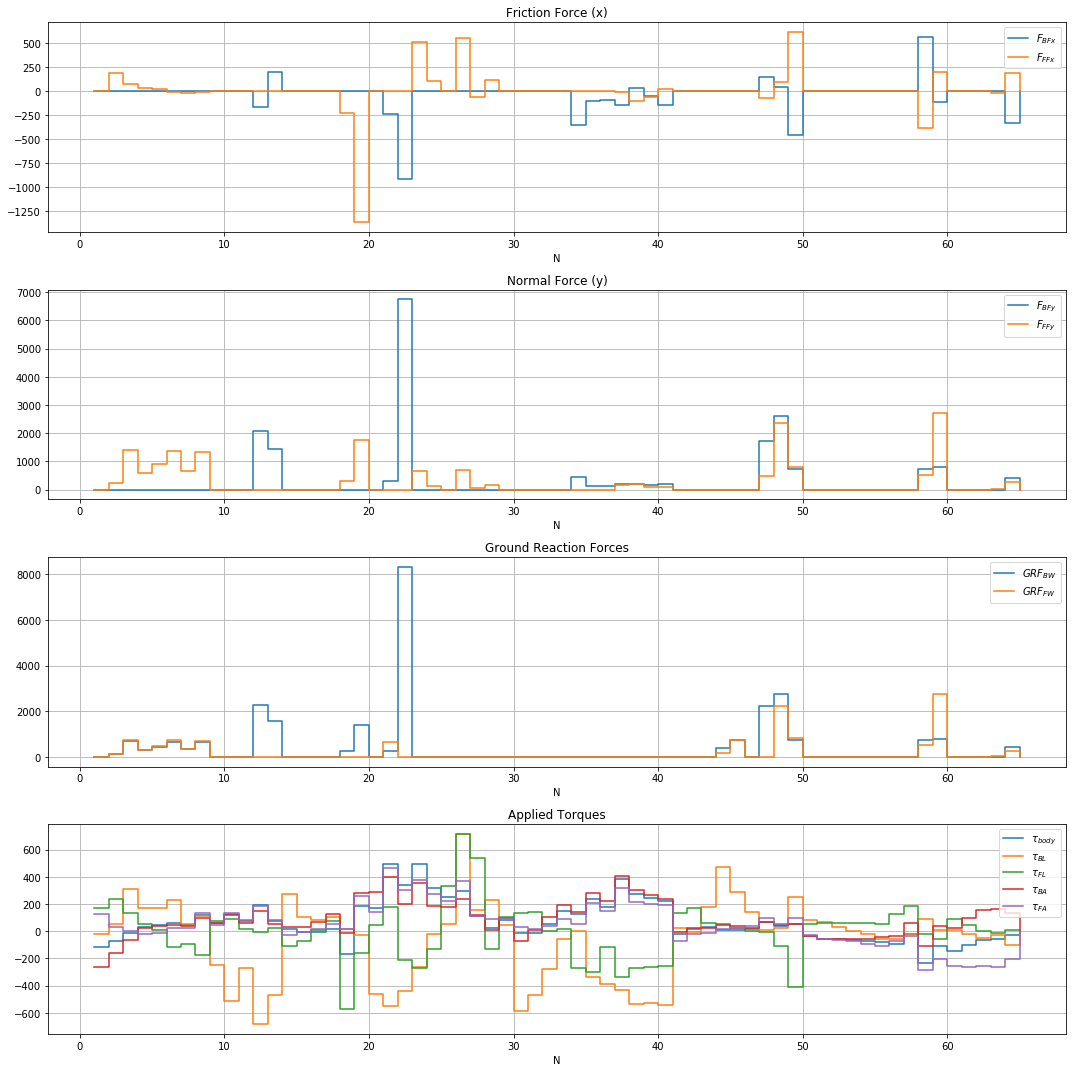

In [146]:
import matplotlib.pyplot as plt

# Plot some of the variables
F_BFxar  = [BW*m.Fb_b_total[i,'BF','x_b']() for i in range(1,N+1)]
F_FFxar  = [BW*m.Fb_b_total[i,'FF','x_b']() for i in range (1,N+1)]
F_BFyar  = [BW*m.Fb_b_total[i,'BF','y_b']() for i in range(1,N+1)]
F_FFyar  = [BW*m.Fb_b_total[i,'FF','y_b']() for i in range (1,N+1)]
GRF_BWar = [BW*m.GRF[i,'BW']() for i in range(1,N+1)]
GRF_FWar = [BW*m.GRF[i,'FW']() for i in range(1,N+1)]
tau_bar = [BW*m.tau_b[i]() for i in range (1,N+1)]
tau_a_BLar = [BW*m.tau_a[i,'BL']() for i in range (1,N+1)]
tau_a_FLar = [BW*m.tau_a[i,'FL']() for i in range (1,N+1)]
tau_arm_BAar = [BW*m.tau_arm[i,'BA']() for i in range (1,N+1)]
tau_arm_FAar = [BW*m.tau_arm[i,'FA']() for i in range (1,N+1)]

# tarr = [m.h[i]() for i in range (1,N+1)]
# t = hm*np.cumsum(np.asarray(tarr))
# t -= t[0]

nar = np.linspace(1,N,N)

plt.figure(figsize=(15, 15))
plt.subplot(4,1,1)
plt.step(nar, F_BFxar,where='post')
plt.step(nar, F_FFxar,where='post')
plt.title('Friction Force (x)')
plt.xlabel('N')
plt.legend([r'$F_{BFx}$',r'$F_{FFx}$'])
plt.grid(True)

plt.subplot(4,1,2)
plt.step(nar, F_BFyar,where='post')
plt.step(nar, F_FFyar,where='post')
plt.title('Normal Force (y)')
plt.xlabel('N')
plt.legend([r'$F_{BFy}$',r'$F_{FFy}$'])
plt.grid(True)

plt.subplot(4,1,3)
plt.step(nar, GRF_BWar,where='post')
plt.step(nar, GRF_FWar,where='post')
plt.title('Ground Reaction Forces')
plt.xlabel('N')
plt.legend([r'$GRF_{BW}$',r'$GRF_{FW}$'])
plt.grid(True)

plt.subplot(4,1,4)
plt.step(nar,tau_bar,where ='post')
plt.step(nar,tau_a_BLar,where ='post')
plt.step(nar,tau_a_FLar,where ='post')
plt.step(nar,tau_arm_BAar,where ='post')
plt.step(nar,tau_arm_FAar,where ='post')
plt.title('Applied Torques')
plt.xlabel('N')
plt.legend([r'$\tau_{body}$',r'$\tau_{BL}$',r'$\tau_{FL}$',r'$\tau_{BA}$',r'$\tau_{FA}$'])
plt.grid(True)

plt.tight_layout()


In [147]:
# maxGRF

In [148]:
from datetime import datetime

now = datetime.now() # dd/mm/YY H:M:S
dt_string = now.strftime("%d_%m_%Y_%H_%M.pkl")

Ns = m.N.bounds()[1]

modelname = 'model_biped_arms_SO_N'+str(Ns)+ '_' + dt_string 
filepath = 'saved_models\\'
filename = filepath+modelname
print(filename)

if (str(results.solver.termination_condition) == "optimal"):
    with open(filename, mode='wb') as file:
        cloudpickle.dump(m, file)
        print("model saved")
else:
    print("model not saved - not optimal solution.")

saved_models\model_biped_arms_SO_N65_30_09_2019_23_28.pkl
model saved
